In [95]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import sqrt
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import pmdarima as pm
from datetime import datetime
import seaborn as sns
import statsmodels.api as sm
import pytest
import xgboost as xgb
from hyperopt import hp, tpe, fmin, STATUS_OK, Trials
from sklearn.metrics import accuracy_score
import re
import warnings
warnings.filterwarnings("ignore")

# Data preprocessing

In [14]:
elect = pd.read_excel("hourly_electricity.xlsx")
elect["date"] = pd.to_datetime(elect["date"], format='%d.%m.%Y')
elect["time"] = elect["date"].astype(str) + " " + elect["hour"].astype(str)
elect["time"] = pd.to_datetime(elect["time"])
elect.sort_values(by = "time", inplace = True)
elect.set_index("time", inplace=True)
elect.drop(columns="hour", inplace = True)
elect.drop(columns="date", inplace=True)

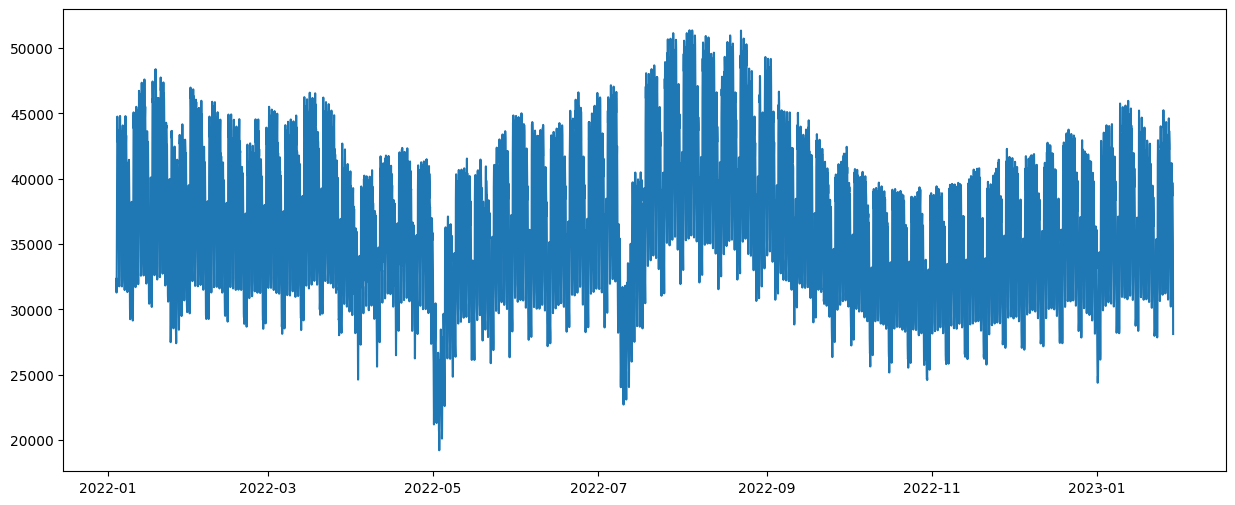

In [15]:
fig, ax = plt.subplots(figsize = (15, 6))
ax.plot(elect.index[-390*24:], elect["electricity"][-390*24:], label = "hourly  electricity consumption")
plt.show()

- We can obserse from the graph above that there is also yearly sesonality besides hourly and weekly data

In [20]:
elect["month"] = elect.index.month_name() # the months are added as dummy variables to captures yearly seasonality 

In [35]:
elect = pd.get_dummies(elect, columns=["month"])

In [36]:
elect.head()

,electricity,month_April,month_August,month_December,month_February,month_January,month_July,month_June,month_March,month_May,month_November,month_October,month_September
time,,,,,,,,,,,,,
2017-01-01 00:00:00,27223.06,0,0,0,0,1,0,0,0,0,0,0,0
2017-01-01 01:00:00,25825.90,0,0,0,0,1,0,0,0,0,0,0,0
2017-01-01 02:00:00,24252.68,0,0,0,0,1,0,0,0,0,0,0,0
2017-01-01 03:00:00,22915.47,0,0,0,0,1,0,0,0,0,0,0,0
2017-01-01 04:00:00,22356.99,0,0,0,0,1,0,0,0,0,0,0,0


- To avoid insignificant lags as predictors in the model, correlation matrix is calculated to find the most corelated lags that can be used as predictors.

In [23]:
corel = pd.DataFrame(elect["electricity"])
for i in range(1, 168+1):
    corel["elec"+str(i)] = corel["electricity"].shift(i)
corel.dropna(inplace=True)
cors = corel.corr()

In [30]:
cors

,electricity,elec1,elec2,elec3,elec4,elec5,elec6,elec7,elec8,elec9,...,elec159,elec160,elec161,elec162,elec163,elec164,elec165,elec166,elec167,elec168
electricity,1.000000,0.967194,0.890248,0.790227,0.680158,0.573325,0.470363,0.374523,0.295605,0.237893,...,0.138247,0.193743,0.270064,0.363028,0.463011,0.566732,0.673445,0.770239,0.844455,0.875419
elec1,0.967194,1.000000,0.967194,0.890260,0.790243,0.680176,0.573344,0.470388,0.374549,0.295624,...,0.102468,0.138253,0.193742,0.270056,0.363017,0.462997,0.566717,0.673432,0.770229,0.844449
elec2,0.890248,0.967194,1.000000,0.967200,0.890269,0.790253,0.680189,0.573361,0.470406,0.374562,...,0.083740,0.102467,0.138248,0.193731,0.270043,0.363001,0.462980,0.566701,0.673419,0.770220
elec3,0.790227,0.890260,0.967200,1.000000,0.967201,0.890269,0.790254,0.680191,0.573364,0.470406,...,0.075996,0.083744,0.102471,0.138251,0.193733,0.270043,0.362999,0.462978,0.566701,0.673419
elec4,0.680158,0.790243,0.890269,0.967201,1.000000,0.967200,0.890269,0.790255,0.680191,0.573363,...,0.075080,0.075996,0.083746,0.102474,0.138254,0.193734,0.270042,0.363000,0.462980,0.566703
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
elec164,0.566732,0.462997,0.363001,0.270043,0.193734,0.138252,0.102472,0.083754,0.076015,0.075099,...,0.573172,0.680060,0.790173,0.890234,0.967194,1.000000,0.967196,0.890246,0.790202,0.680115
elec165,0.673445,0.566717,0.462980,0.362999,0.270042,0.193732,0.138252,0.102482,0.083769,0.076024,...,0.470199,0.573206,0.680082,0.790187,0.890241,0.967196,1.000000,0.967197,0.890248,0.790205
elec166,0.770239,0.673432,0.566701,0.462978,0.363000,0.270042,0.193734,0.138263,0.102499,0.083779,...,0.374348,0.470234,0.573230,0.680098,0.790197,0.890246,0.967197,1.000000,0.967198,0.890248
elec167,0.844455,0.770229,0.673419,0.566701,0.462980,0.363001,0.270045,0.193746,0.138279,0.102509,...,0.295418,0.374381,0.470258,0.573246,0.680109,0.790202,0.890248,0.967198,1.000000,0.967198


In [26]:
lags = list(cors[cors["electricity"]>=0.7].index)[1:] # extracting the lags that are highly correlated with the target

In [28]:
print(lags)

['elec1', 'elec2', 'elec3', 'elec22', 'elec23', 'elec24', 'elec25', 'elec26', 'elec47', 'elec48', 'elec49', 'elec72', 'elec96', 'elec120', 'elec143', 'elec144', 'elec145', 'elec166', 'elec167', 'elec168']


In [31]:
numeric_lags = []
for i in lags:
    match = re.search(r'\d+', i)
    if match:
        numeric_lags.append(int(match.group()))

In [32]:
print(numeric_lags)

[1, 2, 3, 22, 23, 24, 25, 26, 47, 48, 49, 72, 96, 120, 143, 144, 145, 166, 167, 168]


In [38]:
elect.head()

,electricity,month_April,month_August,month_December,month_February,month_January,month_July,month_June,month_March,month_May,month_November,month_October,month_September
time,,,,,,,,,,,,,
2017-01-01 00:00:00,27223.06,0,0,0,0,1,0,0,0,0,0,0,0
2017-01-01 01:00:00,25825.90,0,0,0,0,1,0,0,0,0,0,0,0
2017-01-01 02:00:00,24252.68,0,0,0,0,1,0,0,0,0,0,0,0
2017-01-01 03:00:00,22915.47,0,0,0,0,1,0,0,0,0,0,0,0
2017-01-01 04:00:00,22356.99,0,0,0,0,1,0,0,0,0,0,0,0


Addition of important lags:

In [39]:
for i in numeric_lags:
    elect["elect_lag"+str(i)] = elect["electricity"].shift(i)
    
elect.dropna(inplace=True)

In [41]:
elect.head()

,electricity,month_April,month_August,month_December,month_February,month_January,month_July,month_June,month_March,month_May,...,elect_lag49,elect_lag72,elect_lag96,elect_lag120,elect_lag143,elect_lag144,elect_lag145,elect_lag166,elect_lag167,elect_lag168
time,,,,,,,,,,,,,,,,,,,,,
2017-01-08 00:00:00,30012.14,0,0,0,0,1,0,0,0,0,...,33687.47,31433.88,31313.51,30859.74,25680.13,27477.70,29308.57,24252.68,25825.90,27223.06
2017-01-08 01:00:00,27915.40,0,0,0,0,1,0,0,0,0,...,31338.13,29425.85,29402.67,28943.01,24372.11,25680.13,27477.70,22915.47,24252.68,25825.90
2017-01-08 02:00:00,26599.22,0,0,0,0,1,0,0,0,0,...,29281.03,28252.07,28387.84,27825.29,23884.00,24372.11,25680.13,22356.99,22915.47,24252.68
2017-01-08 03:00:00,25862.16,0,0,0,0,1,0,0,0,0,...,28004.25,27738.40,27778.13,27332.35,23902.65,23884.00,24372.11,22274.49,22356.99,22915.47
2017-01-08 04:00:00,25516.35,0,0,0,0,1,0,0,0,0,...,27371.72,27636.45,27705.95,27254.78,24357.62,23902.65,23884.00,22388.61,22274.49,22356.99


In [42]:
# train data
X_train = elect[:"2022-12-31"].iloc[:, 1:]
Y_train = elect[:"2022-12-31"]["electricity"]
# test data
X_test = elect["2023-01-01":].iloc[:, 1:]
Y_test = elect["2023-01-01":]["electricity"]

# Hyperparameter tuning using hyperopt to use best parameters of XGboost

In [49]:
space={'max_depth': hp.quniform("max_depth", 3, 25, 1),
       'learning_rate': hp.quniform('learning_rate', 0.01, 0.5, 0.0001),
        'gamma': hp.quniform ('gamma', 0, 700, 0.001),
#        'reg_alpha' : hp.quniform('reg_alpha', 0,100,0.01),
        'reg_lambda' : hp.quniform('reg_lambda', 0, 200, 0.001),
#         'colsample_bytree' : hp.uniform('colsample_bytree', 0.5, 1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 9, 0.01),
        'n_estimators': hp.quniform("n_estimators", 200, 2500, 10),
       'colsample_bytree': hp.quniform('colsample_bytree ', 0.5, 1, 0.001),
#        'colsample_bylevel': hp.quniform('colsample_bylevel ', 0.5, 1, 0.001),
#        'colsample_bynode': hp.quniform('colsample_bynode', 0.5, 1, 0.001),
        'seed': 0
    }

In [50]:
def objective(space):
    clf=xgb.XGBRegressor(objective= 'reg:squarederror', n_estimators =int(space['n_estimators']),
                         max_depth = int(space['max_depth']), gamma = space['gamma'],
                         reg_lambda = space['reg_lambda'], colsample_bytree = space['colsample_bytree'],
#                          colsample_bylevel = space['colsample_bylevel'], colsample_bynode = space['colsample_bynode'],
                         min_child_weight=int(space['min_child_weight']), learning_rate = space['learning_rate'])

    
    clf.fit(X_train, Y_train, eval_set = [(X_train, Y_train), (X_test, Y_test)], early_stopping_rounds=15, eval_metric="rmse",
             verbose = False)
    

    yhat = clf.predict(X_test)
    accuracy = (abs(yhat - Y_test)*100/Y_test).mean()
    print ("SCORE:", accuracy)
    return {'loss': accuracy, 'status': STATUS_OK }

In [51]:
trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 150,
                        trials = trials)

SCORE:                                                                                                                 
0.8987337070582387                                                                                                     
SCORE:                                                                                                                 
0.8362688958142394                                                                                                     
SCORE:                                                                                                                 
1.2047406992206962                                                                                                     
SCORE:                                                                                                                 
0.7847758824974518                                                                                                     
SCORE:                                  

SCORE:                                                                                                                 
0.6945789045860353                                                                                                     
SCORE:                                                                                                                 
0.8559088589913554                                                                                                     
SCORE:                                                                                                                 
0.6923450765382163                                                                                                     
SCORE:                                                                                                                 
0.7530744721907315                                                                                                     
SCORE:                                  

SCORE:                                                                                                                 
0.7181633853751895                                                                                                     
SCORE:                                                                                                                 
0.69195441671823                                                                                                       
SCORE:                                                                                                                 
0.7055497707023028                                                                                                     
SCORE:                                                                                                                 
0.739704256253079                                                                                                      
SCORE:                                  

SCORE:                                                                                                                 
0.69945774568259                                                                                                       
SCORE:                                                                                                                 
0.8237392781309714                                                                                                     
SCORE:                                                                                                                 
0.8521662974925835                                                                                                     
SCORE:                                                                                                                 
0.7283852471344354                                                                                                     
SCORE:                                  

SCORE:                                                                                                                 
0.7424253392027667                                                                                                     
SCORE:                                                                                                                 
0.7862943825942313                                                                                                     
SCORE:                                                                                                                 
0.9591299678922622                                                                                                     
SCORE:                                                                                                                 
0.72776800249661                                                                                                       
SCORE:                                  

In [52]:
print("The best hyperparameters are : ","\n")
print(best_hyperparams)

The best hyperparameters are :  

{'colsample_bytree ': 0.764, 'gamma': 176.198, 'learning_rate': 0.026000000000000002, 'max_depth': 15.0, 'min_child_weight': 7.59, 'n_estimators': 2440.0, 'reg_lambda': 56.378}


In [53]:
gma = best_hyperparams["gamma"]
lr = best_hyperparams["learning_rate"]
# lr = 0.02
maxdpt = int(best_hyperparams["max_depth"])
minchild = best_hyperparams["min_child_weight"]
n_est = int(best_hyperparams["n_estimators"])+700
reg_lamd = best_hyperparams["reg_lambda"]
bytre = best_hyperparams["colsample_bytree "]
# bylvl = best_hyperparams["colsample_bylevel "]
# bynode = best_hyperparams["colsample_bynode"]

# Setting XGboost model with best parameters

In [54]:
xb_model = xgb.XGBRegressor(objective= 'reg:squarederror', n_estimators=n_est,
                            learning_rate = lr,
                            max_depth = maxdpt,
                            reg_lambda =reg_lamd,
                            min_child_weight = minchild,
                            colsample_bytree = bytre, 
#                             colsample_bylevel = bylvl, colsample_bynode = bynode,
                            gamma = gma)

In [55]:
xb_model.fit(X_train, Y_train, eval_set = [(X_train, Y_train), (X_test, Y_test)],early_stopping_rounds=15, eval_metric="rmse",
             verbose = True)

[0]	validation_0-rmse:34064.84353	validation_1-rmse:36424.62438
[1]	validation_0-rmse:33187.01746	validation_1-rmse:35484.38045
[2]	validation_0-rmse:32332.00304	validation_1-rmse:34569.06121
[3]	validation_0-rmse:31501.50029	validation_1-rmse:33682.80206
[4]	validation_0-rmse:30690.09271	validation_1-rmse:32810.70705
[5]	validation_0-rmse:29899.80891	validation_1-rmse:31965.34870
[6]	validation_0-rmse:29132.24410	validation_1-rmse:31148.98529
[7]	validation_0-rmse:28382.31681	validation_1-rmse:30346.44917
[8]	validation_0-rmse:27651.73871	validation_1-rmse:29561.46457
[9]	validation_0-rmse:26940.25026	validation_1-rmse:28800.77220
[10]	validation_0-rmse:26247.00667	validation_1-rmse:28055.18662
[11]	validation_0-rmse:25571.88142	validation_1-rmse:27333.05651
[12]	validation_0-rmse:24914.04895	validation_1-rmse:26625.91128
[13]	validation_0-rmse:24273.45902	validation_1-rmse:25941.72878
[14]	validation_0-rmse:23649.40366	validation_1-rmse:25269.69997
[15]	validation_0-rmse:23043.02757	

[129]	validation_0-rmse:1447.14278	validation_1-rmse:1515.02063
[130]	validation_0-rmse:1419.46064	validation_1-rmse:1485.27366
[131]	validation_0-rmse:1392.38906	validation_1-rmse:1456.95504
[132]	validation_0-rmse:1366.74887	validation_1-rmse:1430.08221
[133]	validation_0-rmse:1341.07692	validation_1-rmse:1402.80966
[134]	validation_0-rmse:1316.20883	validation_1-rmse:1376.80438
[135]	validation_0-rmse:1292.79048	validation_1-rmse:1352.71279
[136]	validation_0-rmse:1269.71633	validation_1-rmse:1328.78842
[137]	validation_0-rmse:1247.21195	validation_1-rmse:1304.94987
[138]	validation_0-rmse:1224.78119	validation_1-rmse:1280.61724
[139]	validation_0-rmse:1203.22254	validation_1-rmse:1257.47168
[140]	validation_0-rmse:1182.29608	validation_1-rmse:1234.95912
[141]	validation_0-rmse:1161.69961	validation_1-rmse:1212.10059
[142]	validation_0-rmse:1141.47345	validation_1-rmse:1190.76272
[143]	validation_0-rmse:1122.34286	validation_1-rmse:1171.05207
[144]	validation_0-rmse:1103.39302	valid

[261]	validation_0-rmse:385.23274	validation_1-rmse:462.35776
[262]	validation_0-rmse:383.77369	validation_1-rmse:461.40840
[263]	validation_0-rmse:382.14501	validation_1-rmse:460.35364
[264]	validation_0-rmse:380.57611	validation_1-rmse:459.49345
[265]	validation_0-rmse:379.14171	validation_1-rmse:458.87667
[266]	validation_0-rmse:377.73017	validation_1-rmse:458.23185
[267]	validation_0-rmse:376.15201	validation_1-rmse:457.40838
[268]	validation_0-rmse:374.62307	validation_1-rmse:456.55575
[269]	validation_0-rmse:373.40863	validation_1-rmse:455.92773
[270]	validation_0-rmse:372.12599	validation_1-rmse:455.16945
[271]	validation_0-rmse:370.69877	validation_1-rmse:454.38514
[272]	validation_0-rmse:369.38794	validation_1-rmse:453.59714
[273]	validation_0-rmse:368.22435	validation_1-rmse:452.97432
[274]	validation_0-rmse:367.03403	validation_1-rmse:452.22143
[275]	validation_0-rmse:365.69639	validation_1-rmse:451.71355
[276]	validation_0-rmse:364.72119	validation_1-rmse:451.25104
[277]	va

[394]	validation_0-rmse:272.14642	validation_1-rmse:409.91732
[395]	validation_0-rmse:271.66375	validation_1-rmse:409.81641
[396]	validation_0-rmse:271.21713	validation_1-rmse:409.67522
[397]	validation_0-rmse:270.57324	validation_1-rmse:409.35866
[398]	validation_0-rmse:270.27031	validation_1-rmse:409.32262
[399]	validation_0-rmse:269.68673	validation_1-rmse:409.16114
[400]	validation_0-rmse:269.12045	validation_1-rmse:409.06367
[401]	validation_0-rmse:268.58154	validation_1-rmse:408.98200
[402]	validation_0-rmse:268.23021	validation_1-rmse:408.86216
[403]	validation_0-rmse:267.82517	validation_1-rmse:408.70715
[404]	validation_0-rmse:267.39748	validation_1-rmse:408.58188
[405]	validation_0-rmse:267.09287	validation_1-rmse:408.47366
[406]	validation_0-rmse:266.74913	validation_1-rmse:408.38605
[407]	validation_0-rmse:266.30444	validation_1-rmse:408.14784
[408]	validation_0-rmse:265.98507	validation_1-rmse:407.95885
[409]	validation_0-rmse:265.66791	validation_1-rmse:407.92915
[410]	va

[527]	validation_0-rmse:230.13970	validation_1-rmse:395.14848
[528]	validation_0-rmse:229.99709	validation_1-rmse:395.10131
[529]	validation_0-rmse:229.84006	validation_1-rmse:395.02289
[530]	validation_0-rmse:229.51129	validation_1-rmse:394.92539
[531]	validation_0-rmse:229.33610	validation_1-rmse:394.87310
[532]	validation_0-rmse:229.18911	validation_1-rmse:394.81968
[533]	validation_0-rmse:228.92795	validation_1-rmse:394.54870
[534]	validation_0-rmse:228.64278	validation_1-rmse:394.39267
[535]	validation_0-rmse:228.47841	validation_1-rmse:394.34612
[536]	validation_0-rmse:228.25745	validation_1-rmse:394.17702
[537]	validation_0-rmse:228.10256	validation_1-rmse:394.06549
[538]	validation_0-rmse:227.95789	validation_1-rmse:393.99071
[539]	validation_0-rmse:227.82285	validation_1-rmse:393.94838
[540]	validation_0-rmse:227.66262	validation_1-rmse:393.85241
[541]	validation_0-rmse:227.44988	validation_1-rmse:393.85909
[542]	validation_0-rmse:227.18914	validation_1-rmse:393.68213
[543]	va

[660]	validation_0-rmse:204.83909	validation_1-rmse:387.60460
[661]	validation_0-rmse:204.67129	validation_1-rmse:387.57163
[662]	validation_0-rmse:204.54052	validation_1-rmse:387.54448
[663]	validation_0-rmse:204.46449	validation_1-rmse:387.51939
[664]	validation_0-rmse:204.39516	validation_1-rmse:387.45983
[665]	validation_0-rmse:204.16814	validation_1-rmse:387.39614
[666]	validation_0-rmse:204.04935	validation_1-rmse:387.36546
[667]	validation_0-rmse:203.96494	validation_1-rmse:387.36934
[668]	validation_0-rmse:203.88966	validation_1-rmse:387.33911
[669]	validation_0-rmse:203.79181	validation_1-rmse:387.30015
[670]	validation_0-rmse:203.56014	validation_1-rmse:387.29014
[671]	validation_0-rmse:203.46024	validation_1-rmse:387.24049
[672]	validation_0-rmse:203.18692	validation_1-rmse:387.17249
[673]	validation_0-rmse:203.09899	validation_1-rmse:387.12406
[674]	validation_0-rmse:203.00827	validation_1-rmse:387.08914
[675]	validation_0-rmse:202.89251	validation_1-rmse:387.09075
[676]	va

[793]	validation_0-rmse:187.88803	validation_1-rmse:383.23025
[794]	validation_0-rmse:187.73428	validation_1-rmse:383.21023
[795]	validation_0-rmse:187.69144	validation_1-rmse:383.18950
[796]	validation_0-rmse:187.55161	validation_1-rmse:383.15497
[797]	validation_0-rmse:187.39740	validation_1-rmse:383.08734
[798]	validation_0-rmse:187.20273	validation_1-rmse:382.99029
[799]	validation_0-rmse:187.01525	validation_1-rmse:382.96425
[800]	validation_0-rmse:186.97257	validation_1-rmse:382.95412
[801]	validation_0-rmse:186.86608	validation_1-rmse:382.92204
[802]	validation_0-rmse:186.73530	validation_1-rmse:382.89365
[803]	validation_0-rmse:186.60757	validation_1-rmse:382.87242
[804]	validation_0-rmse:186.49217	validation_1-rmse:382.87284
[805]	validation_0-rmse:186.29466	validation_1-rmse:382.85476
[806]	validation_0-rmse:186.21574	validation_1-rmse:382.79763
[807]	validation_0-rmse:186.16416	validation_1-rmse:382.77298
[808]	validation_0-rmse:186.09069	validation_1-rmse:382.74747
[809]	va

[926]	validation_0-rmse:171.78605	validation_1-rmse:379.72254
[927]	validation_0-rmse:171.66167	validation_1-rmse:379.72991
[928]	validation_0-rmse:171.53117	validation_1-rmse:379.72002
[929]	validation_0-rmse:171.36729	validation_1-rmse:379.72068
[930]	validation_0-rmse:171.27236	validation_1-rmse:379.71483
[931]	validation_0-rmse:171.17436	validation_1-rmse:379.70331
[932]	validation_0-rmse:171.05886	validation_1-rmse:379.72049
[933]	validation_0-rmse:170.94894	validation_1-rmse:379.73394
[934]	validation_0-rmse:170.82263	validation_1-rmse:379.69984
[935]	validation_0-rmse:170.67914	validation_1-rmse:379.63782
[936]	validation_0-rmse:170.58558	validation_1-rmse:379.62533
[937]	validation_0-rmse:170.47887	validation_1-rmse:379.61989
[938]	validation_0-rmse:170.41804	validation_1-rmse:379.60312
[939]	validation_0-rmse:170.28863	validation_1-rmse:379.62544
[940]	validation_0-rmse:170.25213	validation_1-rmse:379.56751
[941]	validation_0-rmse:170.14601	validation_1-rmse:379.52675
[942]	va

[1058]	validation_0-rmse:158.40119	validation_1-rmse:377.68463
[1059]	validation_0-rmse:158.33448	validation_1-rmse:377.70751
[1060]	validation_0-rmse:158.29473	validation_1-rmse:377.70743
[1061]	validation_0-rmse:158.22830	validation_1-rmse:377.70323
[1062]	validation_0-rmse:158.19721	validation_1-rmse:377.68681
[1063]	validation_0-rmse:158.17133	validation_1-rmse:377.68892
[1064]	validation_0-rmse:158.13209	validation_1-rmse:377.65559
[1065]	validation_0-rmse:158.05893	validation_1-rmse:377.66509
[1066]	validation_0-rmse:157.98211	validation_1-rmse:377.63902
[1067]	validation_0-rmse:157.92068	validation_1-rmse:377.63047
[1068]	validation_0-rmse:157.76392	validation_1-rmse:377.61855
[1069]	validation_0-rmse:157.63206	validation_1-rmse:377.59637
[1070]	validation_0-rmse:157.60828	validation_1-rmse:377.58324
[1071]	validation_0-rmse:157.57284	validation_1-rmse:377.57922
[1072]	validation_0-rmse:157.52777	validation_1-rmse:377.54808
[1073]	validation_0-rmse:157.43452	validation_1-rmse:37

[1189]	validation_0-rmse:148.74291	validation_1-rmse:376.52862
[1190]	validation_0-rmse:148.70703	validation_1-rmse:376.51819
[1191]	validation_0-rmse:148.68815	validation_1-rmse:376.50888
[1192]	validation_0-rmse:148.64883	validation_1-rmse:376.46287
[1193]	validation_0-rmse:148.54776	validation_1-rmse:376.43955
[1194]	validation_0-rmse:148.41322	validation_1-rmse:376.45454
[1195]	validation_0-rmse:148.39409	validation_1-rmse:376.44733
[1196]	validation_0-rmse:148.37835	validation_1-rmse:376.44726
[1197]	validation_0-rmse:148.35577	validation_1-rmse:376.43979
[1198]	validation_0-rmse:148.33364	validation_1-rmse:376.42991
[1199]	validation_0-rmse:148.19669	validation_1-rmse:376.43856
[1200]	validation_0-rmse:148.17596	validation_1-rmse:376.42796
[1201]	validation_0-rmse:148.15620	validation_1-rmse:376.43425
[1202]	validation_0-rmse:148.12420	validation_1-rmse:376.43238
[1203]	validation_0-rmse:148.09065	validation_1-rmse:376.43645
[1204]	validation_0-rmse:148.01698	validation_1-rmse:37

[1320]	validation_0-rmse:141.15405	validation_1-rmse:375.63124
[1321]	validation_0-rmse:141.09923	validation_1-rmse:375.63912
[1322]	validation_0-rmse:141.08679	validation_1-rmse:375.64025
[1323]	validation_0-rmse:141.05867	validation_1-rmse:375.64258
[1324]	validation_0-rmse:141.03827	validation_1-rmse:375.62171
[1325]	validation_0-rmse:140.96951	validation_1-rmse:375.63312
[1326]	validation_0-rmse:140.94598	validation_1-rmse:375.63457
[1327]	validation_0-rmse:140.92860	validation_1-rmse:375.63128
[1328]	validation_0-rmse:140.90539	validation_1-rmse:375.64754
[1329]	validation_0-rmse:140.82941	validation_1-rmse:375.59860
[1330]	validation_0-rmse:140.78664	validation_1-rmse:375.58378
[1331]	validation_0-rmse:140.76353	validation_1-rmse:375.57827
[1332]	validation_0-rmse:140.69409	validation_1-rmse:375.58146
[1333]	validation_0-rmse:140.63091	validation_1-rmse:375.51815
[1334]	validation_0-rmse:140.61026	validation_1-rmse:375.51839
[1335]	validation_0-rmse:140.59707	validation_1-rmse:37

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.764, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=176.198, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.026000000000000002,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=15, max_leaves=None,
             min_child_weight=7.59, missing=nan, monotone_constraints=None,
             n_estimators=3140, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [56]:
fi = pd.DataFrame(xb_model.feature_importances_, index= xb_model.feature_names_in_, columns= ["importance"])
fi.sort_values("importance", ascending= False)

,importance
elect_lag1,0.622429
elect_lag167,0.122885
elect_lag168,0.122076
elect_lag2,0.047759
elect_lag23,0.027870
elect_lag24,0.026363
elect_lag26,0.005454
elect_lag22,0.003098
elect_lag3,0.002147
elect_lag145,0.002121


In [57]:
xb_model.predict(X_test)

array([28970.002, 27297.615, 26309.045, 25630.727, 24865.416, 24362.62 ,
       24228.365, 24656.994, 25987.826, 26598.527, 28019.807, 29122.543,
       29520.34 , 30078.824, 30229.5  , 30017.877, 30576.133, 32454.197,
       33050.523, 33323.94 , 33566.953, 32768.41 , 31977.203, 30741.67 ,
       28920.875, 27772.713, 26580.066, 25997.998, 26077.195, 26639.596,
       27870.654, 31382.693, 35468.895, 39671.246, 41308.266, 42306.   ,
       41332.297, 40558.92 , 40696.008, 40999.555, 41535.406, 42072.73 ,
       41564.66 , 40468.574, 39513.723, 37976.53 , 37351.75 , 35698.418,
       33511.805, 31399.37 , 30529.38 , 29841.098, 29576.902, 30013.111,
       31332.936, 34469.027, 38820.465, 42147.4  , 42752.887, 43504.496,
       41927.887, 41530.816, 41915.562, 41571.344, 41712.824, 42223.965,
       41808.9  , 41054.52 , 40043.93 , 39036.496, 37906.285, 36278.805,
       33988.53 , 32259.023, 31045.932, 30295.291, 30345.703, 30606.152,
       31816.941, 34844.297, 39685.93 , 42587.28 , 

In [58]:
act_pred = pd.DataFrame(Y_test)

In [62]:
act_pred["pred"] = xb_model.predict(X_test)
act_pred["mape"] = abs(act_pred["pred"] - act_pred["electricity"])*100/act_pred["electricity"]

In [65]:
#Accuracy:
act_pred["mape"].mean()

0.6807573409429786

# multi-step forecast: predicting the next 29 days (29*24 = 674 hours)

In [79]:
def multi_lag(model, X_test, Y_train, Y_test, l, k):
    
    test_Xgb = X_test.iloc[:, :-k]
    np_test = np.array(test_Xgb)
    last = Y_train[-l:].tolist()
    lags = []
    for x in numeric_lags:
        f = last[-168:][-x]
        lags.append(f)
    
#     lags = np.array((last[-l:][-1], last[-l:][-2], last[-l:][-24], last[-l:][-48], last[-l:][-168]))
    pred = []
    for i in range(len(X_test)):
        if len(last)>l:
            lag = []
            for x in numeric_lags:
                a = last[-168:][-x]
                lag.append(a)
            print(lag)
            inp_new = np.array(lag)
            inp = np.append(np_test[i, :], inp_new)
            x_input = inp.reshape(1,-1)
            yhat = model.predict(x_input)[0]
            pred.append(yhat)
            last.append(yhat)
            print("forecast step "+str(i+1) + " ahead is done")
        else:
            first_inp = np.array(lags)
            print(lags)
            inp = np.append(np_test[i, :], first_inp)
            x_input = inp.reshape(1,-1)
            yhat = model.predict(x_input)[0]
            pred.append(yhat)
            last.append(yhat)
            print("forecast step "+str(i+1) + " ahead is done")
    act_pred = pd.DataFrame(Y_test)
    act_pred["predics"] = pred
    act_pred["mape"] = abs(act_pred["predics"] - act_pred["electricity"])*100/act_pred["electricity"]
    accur = act_pred["mape"].mean()
    
    return act_pred, accur

In [80]:
l = 168
k = len(numeric_lags)

In [81]:
result = multi_lag(xb_model, X_test, Y_train, Y_test, l, k)

[30162.87, 31023.01, 31956.89, 29449.03, 30749.15, 32692.24, 34605.52, 35891.8, 31224.53, 33055.78, 35508.63, 33304.52, 33702.07, 33718.93, 29653.75, 31434.87, 33202.15, 29687.11, 30990.66, 32808.76]
forecast step 1 ahead is done
[28970.002, 30162.87, 31023.01, 28535.8, 29449.03, 30749.15, 32692.24, 34605.52, 29977.7, 31224.53, 33055.78, 31623.72, 31911.91, 31839.61, 28565.5, 29653.75, 31434.87, 28700.22, 29687.11, 30990.66]
forecast step 2 ahead is done
[27471.387, 28970.002, 30162.87, 28134.67, 28535.8, 29449.03, 30749.15, 32692.24, 29433.21, 29977.7, 31224.53, 30506.95, 30755.52, 30921.45, 27916.64, 28565.5, 29653.75, 28337.74, 28700.22, 29687.11]
forecast step 3 ahead is done
[26168.43, 27471.387, 28970.002, 28139.69, 28134.67, 28535.8, 29449.03, 30749.15, 29143.33, 29433.21, 29977.7, 29785.01, 30051.83, 30135.57, 27837.66, 27916.64, 28565.5, 28366.27, 28337.74, 28700.22]
forecast step 4 ahead is done
[25331.092, 26168.43, 27471.387, 28597.6, 28139.69, 28134.67, 28535.8, 29449.03, 

forecast step 85 ahead is done
[38448.31, 40288.59, 40155.586, 39153.523, 39397.145, 39099.11, 39024.137, 40559.406, 38345.934, 37915.58, 37776.32, 30982.129, 34594.73, 36844.03, 39463.92, 38932.46, 38987.24, 40187.23, 40414.58, 40018.72]
forecast step 86 ahead is done
[38478.49, 38448.31, 40288.59, 39603.543, 39153.523, 39397.145, 39099.11, 39024.137, 38329.617, 38345.934, 37915.58, 31205.006, 34072.26, 37939.21, 38928.2, 39463.92, 38932.46, 40771.9, 40187.23, 40414.58]
forecast step 87 ahead is done
[38757.945, 38478.49, 38448.31, 40426.43, 39603.543, 39153.523, 39397.145, 39099.11, 39028.094, 38329.617, 38345.934, 31220.799, 33215.2, 37741.34, 39550.54, 38928.2, 39463.92, 41847.3, 40771.9, 40187.23]
forecast step 88 ahead is done
[38332.195, 38757.945, 38478.49, 40404.3, 40426.43, 39603.543, 39153.523, 39397.145, 40131.156, 39028.094, 38329.617, 31894.639, 33109.62, 38134.47, 41157.43, 39550.54, 38928.2, 41523.65, 41847.3, 40771.9]
forecast step 89 ahead is done
[38795.957, 38332.19

forecast step 171 ahead is done
[28187.232, 29508.34, 31146.527, 28818.857, 28763.19, 29094.342, 29836.912, 31091.06, 28951.934, 29241.963, 29783.414, 29142.184, 29073.357, 28756.248, 25289.66, 25253.996, 25882.0, 24701.943, 24858.64, 25331.092]
forecast step 172 ahead is done
[27413.266, 28187.232, 29508.34, 29482.328, 28818.857, 28763.19, 29094.342, 29836.912, 29164.656, 28951.934, 29241.963, 29005.807, 29046.762, 28723.512, 25877.643, 25289.66, 25253.996, 24534.18, 24701.943, 24858.64]
forecast step 173 ahead is done
[27132.678, 27413.266, 28187.232, 31715.45, 29482.328, 28818.857, 28763.19, 29094.342, 30251.047, 29164.656, 28951.934, 29361.387, 29424.637, 29045.23, 27602.78, 25877.643, 25289.66, 24651.33, 24534.18, 24701.943]
forecast step 174 ahead is done
[26992.0, 27132.678, 27413.266, 34871.74, 31715.45, 29482.328, 28818.857, 28763.19, 33246.56, 30251.047, 29164.656, 30280.375, 30644.549, 30579.092, 31164.021, 27602.78, 25877.643, 25775.674, 24651.33, 24534.18]
forecast step 17

forecast step 264 ahead is done
[34851.65, 36253.89, 37268.805, 29677.67, 30838.574, 32561.484, 34654.695, 36093.64, 30570.928, 32209.686, 34204.258, 29543.754, 31146.527, 32899.832, 30917.697, 32631.703, 34812.332, 29739.148, 30776.92, 32486.605]
forecast step 265 ahead is done
[32491.799, 34851.65, 36253.89, 29004.691, 29677.67, 30838.574, 32561.484, 34654.695, 29395.164, 30570.928, 32209.686, 27954.299, 29508.34, 31091.06, 29783.414, 30917.697, 32631.703, 29142.184, 29739.148, 30776.92]
forecast step 266 ahead is done
[30776.645, 32491.799, 34851.65, 28904.78, 29004.691, 29677.67, 30838.574, 32561.484, 28696.914, 29395.164, 30570.928, 27094.861, 28187.232, 29836.912, 29241.963, 29783.414, 30917.697, 29005.807, 29142.184, 29739.148]
forecast step 267 ahead is done
[29805.9, 30776.645, 32491.799, 29193.21, 28904.78, 29004.691, 29677.67, 30838.574, 28610.453, 28696.914, 29395.164, 26619.84, 27413.266, 29094.342, 28951.934, 29241.963, 29783.414, 29361.387, 29005.807, 29142.184]
forecast

forecast step 352 ahead is done
[33781.844, 33575.684, 33284.785, 38837.56, 38583.0, 37503.965, 37700.72, 38181.69, 39973.836, 39361.938, 39438.17, 40268.246, 39682.24, 39470.766, 39736.832, 39114.496, 38824.16, 34785.965, 34011.492, 32821.7]
forecast step 353 ahead is done
[34264.953, 33781.844, 33575.684, 37865.582, 38837.56, 38583.0, 37503.965, 37700.72, 39965.68, 39973.836, 39361.938, 40898.316, 40288.867, 40033.176, 39673.5, 39736.832, 39114.496, 34316.156, 34785.965, 34011.492]
forecast step 354 ahead is done
[35394.387, 34264.953, 33781.844, 37041.75, 37865.582, 38837.56, 38583.0, 37503.965, 38780.22, 39965.68, 39973.836, 40808.99, 40233.242, 39973.016, 38576.08, 39673.5, 39736.832, 33807.418, 34316.156, 34785.965]
forecast step 355 ahead is done
[35850.434, 35394.387, 34264.953, 36205.96, 37041.75, 37865.582, 38837.56, 38583.0, 37904.75, 38780.22, 39965.68, 39575.543, 39132.336, 38971.797, 37684.09, 38576.08, 39673.5, 33143.324, 33807.418, 34316.156]
forecast step 356 ahead is 

forecast step 446 ahead is done
[41495.582, 41622.203, 43216.19, 40867.254, 40762.35, 41384.17, 41395.965, 41494.234, 40739.875, 41282.46, 41370.63, 41105.547, 33575.684, 38181.69, 39438.17, 39928.066, 39505.3, 40268.246, 40034.453, 40548.3]
forecast step 447 ahead is done
[41411.63, 41495.582, 41622.203, 41334.855, 40867.254, 40762.35, 41384.17, 41395.965, 40799.76, 40739.875, 41282.46, 40630.46, 33781.844, 37700.72, 39361.938, 39438.17, 39928.066, 40898.316, 40268.246, 40034.453]
forecast step 448 ahead is done
[40762.266, 41411.63, 41495.582, 40676.93, 41334.855, 40867.254, 40762.35, 41384.17, 41174.73, 40799.76, 40739.875, 40618.344, 34264.953, 37503.965, 39973.836, 39361.938, 39438.17, 40808.99, 40898.316, 40268.246]
forecast step 449 ahead is done
[40758.74, 40762.266, 41411.63, 39554.82, 40676.93, 41334.855, 40867.254, 40762.35, 40610.246, 41174.73, 40799.76, 40906.49, 35394.387, 38583.0, 39965.68, 39973.836, 39361.938, 39575.543, 40808.99, 40898.316]
forecast step 450 ahead is 

forecast step 531 ahead is done
[28015.371, 29024.295, 30601.475, 27456.295, 27572.348, 27859.004, 28702.805, 29873.541, 29085.607, 29444.904, 30111.428, 29612.373, 29483.395, 29460.004, 29165.662, 29485.877, 30043.252, 27471.672, 27067.402, 27138.025]
forecast step 532 ahead is done
[27481.934, 28015.371, 29024.295, 27534.648, 27456.295, 27572.348, 27859.004, 28702.805, 29091.557, 29085.607, 29444.904, 29469.918, 29207.148, 29219.215, 29567.867, 29165.662, 29485.877, 28883.857, 27471.672, 27067.402]
forecast step 533 ahead is done
[27330.422, 27481.934, 28015.371, 28166.746, 27534.648, 27456.295, 27572.348, 27859.004, 29731.969, 29091.557, 29085.607, 29722.715, 29524.115, 29607.463, 30773.36, 29567.867, 29165.662, 32700.4, 28883.857, 27471.672]
forecast step 534 ahead is done
[27659.32, 27330.422, 27481.934, 29604.822, 28166.746, 27534.648, 27456.295, 27572.348, 32204.084, 29731.969, 29091.557, 30934.469, 30701.055, 30801.334, 33903.52, 30773.36, 29567.867, 37791.914, 32700.4, 28883.8

forecast step 622 ahead is done
[38095.16, 39056.312, 40098.75, 33488.406, 35787.836, 37135.406, 38020.973, 38980.71, 35421.63, 36883.18, 37649.637, 36532.05, 33642.59, 35026.137, 35060.812, 36261.64, 36978.258, 33183.43, 35487.535, 36724.684]
forecast step 623 ahead is done
[37208.25, 38095.16, 39056.312, 31656.375, 33488.406, 35787.836, 37135.406, 38020.973, 33147.87, 35421.63, 36883.18, 35155.914, 32547.457, 33720.05, 33000.703, 35060.812, 36261.64, 31412.53, 33183.43, 35487.535]
forecast step 624 ahead is done
[35910.215, 37208.25, 38095.16, 30570.303, 31656.375, 33488.406, 35787.836, 37135.406, 31421.303, 33147.87, 35421.63, 33037.54, 30601.475, 31654.693, 31200.469, 33000.703, 35060.812, 30300.527, 31412.53, 33183.43]
forecast step 625 ahead is done
[33494.086, 35910.215, 37208.25, 29988.379, 30570.303, 31656.375, 33488.406, 35787.836, 30330.879, 31421.303, 33147.87, 31225.574, 29024.295, 29873.541, 30111.428, 31200.469, 33000.703, 29612.373, 30300.527, 31412.53]
forecast step 62

In [88]:
#accuracy (MAE) for the text 674 hours:
result[1] 

4.762402322940506

In [94]:
result[0].head(24) # forecast of next 24 hours

,electricity,predics,mape
time,,,
2023-01-01 00:00:00,28816.55,28970.001953,0.532513
2023-01-01 01:00:00,27589.25,27471.386719,0.427207
2023-01-01 02:00:00,26328.82,26168.429688,0.609182
2023-01-01 03:00:00,25224.40,25331.091797,0.422971
2023-01-01 04:00:00,24636.46,24858.640625,0.901837
2023-01-01 05:00:00,24376.01,24701.943359,1.337107
2023-01-01 06:00:00,24487.64,24534.179688,0.190054
2023-01-01 07:00:00,24861.35,24651.330078,0.844765
2023-01-01 08:00:00,24809.38,25775.673828,3.894873


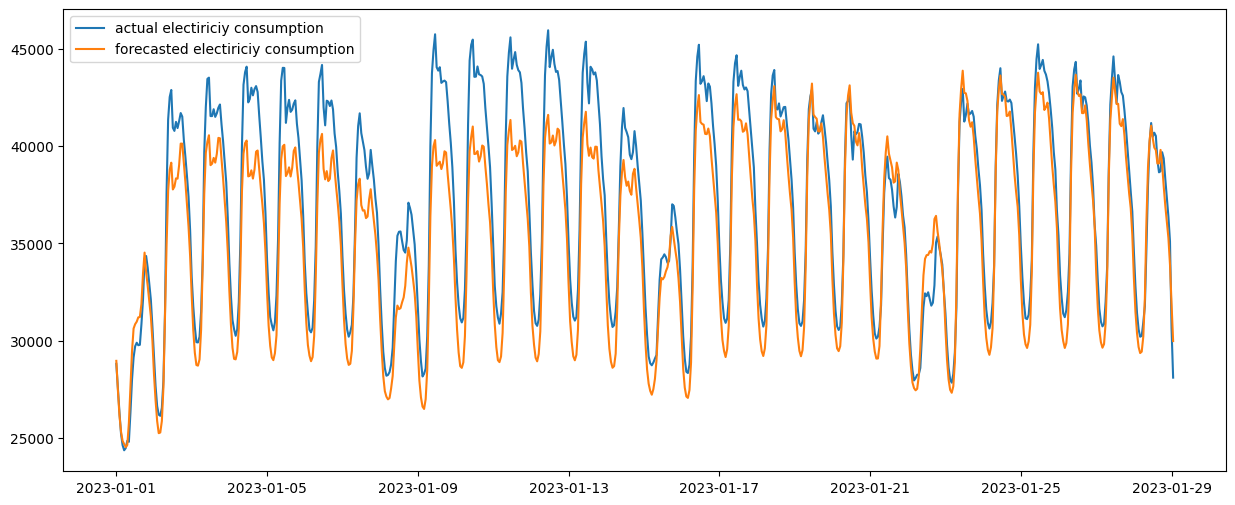

In [92]:
fig, ax = plt.subplots(figsize = (15,6))
ax.plot(result[0].index, result[0]["electricity"], label = "actual electiriciy consumption", color = "C0")
ax.plot(result[0].index, result[0]["predics"], label = "forecasted electiriciy consumption", color = "C1")
plt.legend(loc="upper left")
plt.show()